In [1]:
# pip install yellowbrick

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
import textwrap
import missingno as msno
from sklearn.decomposition import PCA,KernelPCA
from sklearn.manifold import MDS,TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import prince
from yellowbrick.cluster import KElbowVisualizer

In [3]:
os.chdir('D:\\MIT_Micromaster\\ELSA')

In [4]:
dforg = pd.read_csv('Copy of Data - encuesta organizacional 2023.csv')
dfper = pd.read_csv('data_adicional.csv')

In [5]:
per = pd.read_excel('Copy of Preguntas - ELSA 4.xlsx','Preguntas - EP',usecols=['Enunciado Pregunta','Categoria','Serial Code'])
org = pd.read_excel('Copy of Preguntas - ELSA 4.xlsx','Preguntas - EO',usecols=['Enunciado Pregunta','Categoria','Serial Code'])
org = org.iloc[0:136]

In [6]:
per.columns = ['pregunta','categoria','code']
org.columns = ['pregunta','categoria','code']

per['code'] = per['code'].str.lower()
org['code'] = org['code'].str.lower()

In [7]:
def funcion(x):
    if x<=199:
        return 'small'
    elif x<=999:
        return 'medium'
    else:
        return 'large'

# dfper['tamaño'] = dfper.apply(lambda x: funcion(x['poblacion']),axis=1)

# Analisis missing

In [8]:
dfper = dfper[dfper['ip_002'].notnull()].reset_index(drop=True).copy()

In [9]:
# Idea continuar la separacion. Y en el dataset acoso=0 y testigo=0 agrupar por su concepcion y percepcion.

# Creando target

In [10]:
acoso_tecnico = [col for col in dfper.columns if 'at_' in col]
dfper['Acoso_Tecnico'] = dfper[acoso_tecnico].apply(lambda row: 1 if any(row == 'Sí, me ha pasado.') else 0, axis=1)

In [11]:
testigos_tecnicos = [col for col in dfper.columns if 'tt_' in col]
dfper['Testigo_Tecnico'] = dfper[testigos_tecnicos].apply(lambda row: 1 if any(row == 'Sí, he sido testigo.') else 0, axis=1)

In [12]:
dfper['Acoso_Declarado'] = dfper[['ad_001','ad_014']].apply(lambda row: 1 if any(row == 'Sí, me ha pasado.') else 0, axis=1)

In [13]:
dfper['Testigo_Declarado'] = dfper[['td_001']].apply(lambda row: 1 if any(row == 'Sí, he sido testigo de hostigamiento o acoso sexual.') else 0, axis=1)

In [14]:
acoso_total = [col for col in dfper.columns if 'Acoso' in col]
dfper['Acoso_Total'] = dfper[acoso_total].apply(lambda row: 1 if any(row == 1) else 0, axis=1)

In [15]:
dfper.groupby(['Acoso_Total','Acoso_Tecnico','Acoso_Declarado']).agg(CTD=('measurement_process_id','count'))

CTD
Acoso_Total Acoso_Tecnico Acoso_Declarado       
0           0             0                21758
1           0             1                 3233
            1             0                 3331
                          1                  875

In [16]:
testigo_total = [col for col in dfper.columns if 'Testigo' in col]
dfper['Testigo_Total'] = dfper[testigo_total].apply(lambda row: 1 if any(row == 1) else 0, axis=1)

In [17]:
dfper.groupby(['Testigo_Total','Testigo_Tecnico','Testigo_Declarado']).agg(CTD=('measurement_process_id','count'))

CTD
Testigo_Total Testigo_Tecnico Testigo_Declarado       
0             0               0                  23217
1             0               1                   1414
              1               0                   4566

In [18]:
dfper['target'] = dfper['Acoso_Total']+dfper['Testigo_Total']

In [19]:
dfper.groupby(['target','Acoso_Total','Testigo_Total']).agg(CTD=('measurement_process_id','count'))

CTD
target Acoso_Total Testigo_Total       
0      0           0              19653
1      0           1               2105
       1           0               3564
2      1           1               3875

In [20]:
dfper['Acoso_Total'].value_counts(normalize=True)

0    0.745214
1    0.254786
Name: Acoso_Total, dtype: float64

In [21]:
# La proporcion de los dataset se modifica de 18-82 a 33-67
dfper['target'].value_counts(normalize=True)

0    0.673117
1    0.194164
2    0.132719
Name: target, dtype: float64

# Dividiendo el dataset

In [22]:
df_tmp1 = dfper[dfper['target']==0].copy()

## Dataset target 0

In [23]:
list_n_categorias = []
list_pct_cat_mayoritaria = []
list_pct_cat_minoritaria = []
list_cat_mayoritaria = []
list_cat_minoritaria = []

for col in df_tmp1.columns:
    n_categorias = df_tmp1[col].value_counts().shape[0]
    if n_categorias > 0: 
        list_n_categorias.append(n_categorias)
        pct_cat_mayoritaria = df_tmp1[col].value_counts(normalize=True).sort_values(ascending=False).values[0]
        pct_cat_minoritaria = df_tmp1[col].value_counts(normalize=True).sort_values(ascending=False).values[-1]
        list_pct_cat_mayoritaria.append(pct_cat_mayoritaria)
        list_pct_cat_minoritaria.append(pct_cat_minoritaria)
        cat_mayoritaria = df_tmp1[col].value_counts(normalize=True).sort_values(ascending=False).index[0]
        cat_minoritaria = df_tmp1[col].value_counts(normalize=True).sort_values(ascending=False).index[-1]
        list_cat_mayoritaria.append(cat_mayoritaria)
        list_cat_minoritaria.append(cat_minoritaria)
    else:
        list_n_categorias.append(np.nan)
        list_pct_cat_mayoritaria.append(np.nan)
        list_pct_cat_minoritaria.append(np.nan)

In [24]:
tmp = pd.DataFrame(zip(df_tmp1.columns,list_n_categorias,list_pct_cat_mayoritaria,list_pct_cat_minoritaria),columns=['variable','n_categorias','pct_max','pct_min'])
tmp = tmp.sort_values('n_categorias')
tmp = tmp.reset_index(drop=True)

In [25]:
unicat = tmp[(tmp['n_categorias'].isnull())|(tmp['n_categorias']==1)]['variable'].tolist()

In [26]:
info_per = [columna for columna in tmp['variable'] if columna.startswith('ip')]
info_lab = [columna for columna in tmp['variable'] if columna.startswith('il')]
info_ad = [columna for columna in tmp['variable'] if columna.startswith('ad')]
info_td = [columna for columna in tmp['variable'] if columna.startswith('td')]

In [27]:
df_tmp1 = df_tmp1.drop(unicat+['measurement_process_id']+info_per+info_lab+info_ad+info_td,axis=1)

In [28]:
"""
Analisis MCA:
- Varianza explicada con 2 componentes = 10%
- Varianza explicada con 5 componentes = 18%
"""
# mca = prince.MCA(n_components=5,random_state=42)

'\nAnalisis MCA:\n- Varianza explicada con 2 componentes = 10%\n- Varianza explicada con 5 componentes = 18%\n'

# Tratamiento de missing

## Analisis de missing

In [29]:
m_per = pd.DataFrame({'n_missing': dfper.isnull().sum(), 'pct_missing': dfper.isnull().mean()*100})
m_per = m_per.sort_values('pct_missing',ascending=True)
m_per = m_per.reset_index()
m_per = m_per.rename(columns={'index':'code'})
m_per = per.merge(m_per,on='code',how='right')

## Tratamiento

In [30]:
# var_list = m_per[(m_per['categoria']=='Acoso Declarado')&(m_per['n_missing']!=0)&(m_per['code']!='ad_014')]
# var_list = var_list['code'].sort_values()
# var_list = list(var_list.values)

In [31]:
# df_tmp1[var_list] = df_tmp1[var_list].fillna('No aplica')

In [32]:
# var_list = m_per[m_per['categoria']=='Acciones Acoso Declarado']
# var_list = var_list['code'].sort_values()
# var_list = list(var_list.values)

In [33]:
# df_tmp1[var_list] = df_tmp1[var_list].fillna('No aplica')

In [34]:
# var_list = m_per[(m_per['categoria']=='Testigos Declarados')&(m_per['n_missing']!=1)]
# var_list = var_list['code'].sort_values()
# var_list = list(var_list.values)

In [35]:
# df_tmp1[var_list] = df_tmp1[var_list].fillna('No aplica')

In [36]:
# var_list = m_per[m_per['categoria']=='Acciones Testigos']
# var_list = var_list['code'].sort_values()
# var_list = list(var_list.values)

In [37]:
# df_tmp1[var_list] = df_tmp1[var_list].fillna('No aplica')

In [38]:
# var_list = m_per[(m_per['categoria']=='Barreras de denuncia')&(m_per['code']!='bad_010')]
# var_list = var_list['code'].sort_values()
# var_list = list(var_list.values)

In [39]:
# df_tmp1[var_list] = df_tmp1[var_list].fillna('No aplica')

In [40]:
# var_list = m_per[(m_per['categoria']=='Costos')]
# var_list = var_list['code'].sort_values()
# var_list = list(var_list.values)

In [41]:
# df_tmp1[var_list] = df_tmp1[var_list].fillna('No aplica')

In [42]:
# df_tmp1['fre_001'] = df_tmp1['fre_001'].fillna('No aplica')

In [43]:
df_tmp1['pl_001'] = df_tmp1['pl_001'].fillna('No aplica')

df_tmp1 = df_tmp1.drop(columns=['pl_001'])

In [44]:
# var_list = m_per[(m_per['categoria']=='Perfil Acosador - Declarado')]
# var_list = var_list['code'].sort_values()
# var_list = list(var_list.values)

In [45]:
# df_tmp1[var_list] = df_tmp1[var_list].fillna('No aplica')

In [46]:
# var_list = m_per[(m_per['categoria']=='Acoso Técnico')]
# var_list = var_list['code'].sort_values()
# var_list = list(var_list.values)

In [47]:
# df_tmp1[var_list] = df_tmp1[var_list].fillna('No aplica')

In [48]:
# var_list = m_per[(m_per['categoria']=='Testigos Técnicos')]
# var_list = var_list['code'].sort_values()
# var_list = list(var_list.values)

In [49]:
# df_tmp1[var_list] = df_tmp1[var_list].fillna('No aplica')

In [50]:
var_list = [col for col in dfper.columns if 'case_' in col]
df_tmp1[var_list] = df_tmp1[var_list].fillna('No aplica')

df_tmp1 = df_tmp1.drop(columns=var_list)

### Analizando correlacion de casos con otras variables

In [51]:
from scipy.stats import chi2_contingency

In [52]:
def cramerV(label,x):
    confusion_matrix = pd.crosstab(label, x)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r,k = confusion_matrix.shape
    phi2 = chi2/n
    phi2corr = max(0,phi2-((k-1)*(r-1))/(n-1))
    rcorr = r - ((r - 1) ** 2) / ( n - 1 )
    kcorr = k - ((k - 1) ** 2) / ( n - 1 )
    try:
        if min((kcorr - 1),(rcorr - 1)) == 0:
            warnings.warn(
            "Unable to calculate Cramer's V using bias correction. Consider not using bias correction",RuntimeWarning)
            v = 0
            print("If condition Met: ",v)
        else:
            v = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
            print("Else condition Met: ",v)
    except:
        print("inside error")
        v = 0
    return v

In [53]:
def plot_cramer(df):
    cramer = pd.DataFrame(index=df.columns,columns=df.columns)
    for column_of_interest in df.columns:
        try:
            temp = {}

            columns = df.columns
            for j in range(0,len(columns)):
                v = cramerV(df[column_of_interest],df[columns[j]])
                cramer.loc[column_of_interest,columns[j]] = v
                if (column_of_interest==columns[j]):
                    pass
                else:
                    temp[columns[j]] = v
            cramer.fillna(value=np.nan,inplace=True)
        except:
            print('Dropping row:',column_of_interest)
            pass
    return cramer

In [54]:
# cramer_corr = plot_cramer(df_tmp1) 

In [55]:
# cramer_corr = cramer_corr.reset_index()

In [56]:
# cramer_corr.to_csv('correlacion_dataset_1_2.csv',index=False)

In [57]:
temporal = pd.DataFrame(df_tmp1.isnull().sum(),columns=['n_missing'])
temporal= temporal.sort_values('n_missing')

In [58]:
temporal = temporal.reset_index()

In [59]:
for i in temporal[temporal['n_missing']>0]['index'].values:
    moda = df_tmp1[i].mode().values[0]
#     print(i,moda)
    df_tmp1[i] = df_tmp1[i].fillna(moda)

In [60]:
# df_tmp1 = df_tmp1.drop('measurement_process_id',axis=1)

# Codificacion de variables

In [61]:
def cat_to_dummies(df,columna):
    unique_cats = list(df[f'{columna}'].unique())
    unique_dict = dict(zip(unique_cats,[f'{columna}_{i}' for i in range(len(unique_cats))]))
    out = pd.get_dummies(df[f'{columna}']).rename(columns=unique_dict)
    print(unique_dict)
    return out

In [62]:
# Mejora: Retirar variable genero para no distinguir entre generos, sino por acontecimientos que le ocurren a cada colaborador
# tmp = cat_to_dummies(df_tmp1,'ip_001')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['ip_001'])

In [63]:
# tmp = cat_to_dummies(df_tmp1,'ip_002')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['ip_002'])

In [64]:
# tmp = cat_to_dummies(df_tmp1,'ip_003')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['ip_003'])

In [65]:
# Mejora: Retirar variable raza para no distinguir entre generos, sino por acontecimientos que le ocurren a cada colaborador
# tmp = cat_to_dummies(df_tmp1,'ip_004')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['ip_004'])

In [66]:
# tmp = cat_to_dummies(df_tmp1,'il_001')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['il_001'])

In [67]:
# tmp = cat_to_dummies(df_tmp1,'il_002')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['il_002'])

In [68]:
# dicc = {'Menos de 3 meses.':1,
#          'Entre 3 meses y 1 año.':2,
#          'Entre 1 y 5 años.':3,
#          'Entre 5 y 10 años.':4,
#          'Hace más de 10 años.':5}
# df_tmp1['il_003'] = df_tmp1['il_003'].replace(dicc)

In [69]:
# tmp = cat_to_dummies(df_tmp1,'il_004')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['il_004'])

In [70]:
# tmp = cat_to_dummies(df_tmp1,'il_005')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['il_005'])

In [71]:
# tmp = cat_to_dummies(df_tmp1,'il_006')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['il_006'])

In [72]:
# tmp = cat_to_dummies(df_tmp1,'il_007')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['il_007'])

In [73]:
# tmp = cat_to_dummies(df_tmp1,'il_008')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['il_008'])

In [74]:
# tmp = cat_to_dummies(df_tmp1,'il_009')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['il_009'])

In [75]:
tmp = cat_to_dummies(df_tmp1,'name')
df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
df_tmp1 = df_tmp1.drop(columns=['name'])

{'Servicios financieros y seguros': 'name_0', 'Minero y energético': 'name_1', 'Industria Farmacéutica, farmacéutica y salud': 'name_2', 'Comercio': 'name_3', 'Comunicaciones y tecnología': 'name_4', 'Servicios a empresas': 'name_5', 'Productos alimenticios y bebidas': 'name_6', 'Industria': 'name_7'}


In [76]:
tmp = cat_to_dummies(df_tmp1,'sp_001')
df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
df_tmp1 = df_tmp1.drop(columns=['sp_001'])

{'Sé que existe pero no la he revisado.': 'sp_001_0', 'Sí, la he revisado.': 'sp_001_1', 'No.': 'sp_001_2'}


In [77]:
tmp = cat_to_dummies(df_tmp1,'sp_002')
df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
df_tmp1 = df_tmp1.drop(columns=['sp_002'])

{'Sí, una vez.': 'sp_002_0', 'Sí, más de una vez.': 'sp_002_1', 'No, nunca.': 'sp_002_2'}


In [78]:
tmp = cat_to_dummies(df_tmp1,'sp_003')
df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
df_tmp1 = df_tmp1.drop(columns=['sp_003'])

{'Sé que existe pero no sé cómo acceder a él.': 'sp_003_0', 'Sí, y sé cómo acceder a él.': 'sp_003_1', 'No.': 'sp_003_2'}


In [79]:
df_tmp1['sp_004'] = df_tmp1['sp_004'].replace({True:1,False:0})
df_tmp1['sp_005'] = df_tmp1['sp_005'].replace({True:1,False:0})
df_tmp1['sp_006'] = df_tmp1['sp_006'].replace({True:1,False:0})
df_tmp1['sp_007'] = df_tmp1['sp_007'].replace({True:1,False:0})
df_tmp1['sp_008'] = df_tmp1['sp_008'].replace({True:1,False:0})
# df_tmp1['sp_009'] = df_tmp1['sp_009'].replace({True:1,False:0})
df_tmp1['sp_010'] = df_tmp1['sp_010'].replace({True:1,False:0})
df_tmp1['sp_011'] = df_tmp1['sp_011'].replace({True:1,False:0})

In [80]:
tmp = cat_to_dummies(df_tmp1,'sp_012')
df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
df_tmp1 = df_tmp1.drop(columns=['sp_012'])

{'No.': 'sp_012_0', 'Sí, lo he revisado.': 'sp_012_1'}


In [81]:
# tmp = cat_to_dummies(df_tmp1,'pl_001')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['pl_001'])

In [82]:
tolerancia = [col for col in df_tmp1.columns if col.startswith('tol')&(len(col)<8)]

In [83]:
for columna in tolerancia:
    tmp = cat_to_dummies(df_tmp1,columna)
    df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
    df_tmp1 = df_tmp1.drop(columns=[columna])

{'Es hostigamiento o acoso sexual en el trabajo.': 'tol_001_0', 'No son formas de comportarse en el trabajo, pero no es acoso.': 'tol_001_1', 'Es hostigamiento o acoso, pero no es sexual.': 'tol_001_2', 'No veo nada de malo con esa situación.': 'tol_001_3'}
{'Es hostigamiento o acoso sexual en el trabajo.': 'tol_002_0', 'No son formas de comportarse en el trabajo, pero no es acoso.': 'tol_002_1', 'Es hostigamiento o acoso, pero no es sexual.': 'tol_002_2', 'No veo nada de malo con esa situación.': 'tol_002_3'}
{'Es hostigamiento o acoso sexual en el trabajo.': 'tol_003_0', 'Es hostigamiento o acoso, pero no es sexual.': 'tol_003_1', 'No son formas de comportarse en el trabajo, pero no es acoso.': 'tol_003_2', 'No veo nada de malo con esa situación.': 'tol_003_3'}
{'Es hostigamiento o acoso sexual en el trabajo.': 'tol_004_0', 'Es hostigamiento o acoso, pero no es sexual.': 'tol_004_1', 'No son formas de comportarse en el trabajo, pero no es acoso.': 'tol_004_2', 'No veo nada de malo co

In [84]:
df_tmp1['cpt_001'] = df_tmp1['cpt_001'].replace({'Sí.':1,'No.':0})
df_tmp1['cpt_002'] = df_tmp1['cpt_002'].replace({'Sí.':1,'No.':0})
df_tmp1['cpt_003'] = df_tmp1['cpt_003'].replace({'Sí.':1,'No.':0})
df_tmp1['cpt_004'] = df_tmp1['cpt_004'].replace({'Sí.':1,'No.':0})

In [85]:
# En este ejercicio eliminar acoso declarado podria ser adecuado
# tmp = cat_to_dummies(df_tmp1,'ad_001')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['ad_001'])

In [86]:
# tmp = cat_to_dummies(df_tmp1,'ad_014')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['ad_014'])

In [87]:
# vars_analysis = [col for col in df_tmp1.columns if (col.startswith('ad')&(len(col)==6))]

In [88]:
# for columna in vars_analysis:
#     tmp = cat_to_dummies(df_tmp1,columna)
#     df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
#     df_tmp1 = df_tmp1.drop(columns=[columna])

In [89]:
# vars_analysis = [col for col in df_tmp1.columns if (col.startswith('pad'))]

In [90]:
# for columna in vars_analysis:
#     tmp = cat_to_dummies(df_tmp1,columna)
#     df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
#     df_tmp1 = df_tmp1.drop(columns=[columna])

In [91]:
# vars_analysis = [col for col in df_tmp1.columns if (col.startswith('aad')&(len(col)==7))]

In [92]:
# for columna in vars_analysis:
#     tmp = cat_to_dummies(df_tmp1,columna)
#     df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
#     df_tmp1 = df_tmp1.drop(columns=[columna])

In [93]:
# vars_analysis = [col for col in df_tmp1.columns if (col.startswith('bad'))]

In [94]:
# for columna in vars_analysis:
#     tmp = cat_to_dummies(df_tmp1,columna)
#     df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
#     df_tmp1 = df_tmp1.drop(columns=[columna])

In [95]:
# vars_analysis = [col for col in df_tmp1.columns if (col.startswith('at'))]

In [96]:
# for columna in vars_analysis:
#     tmp = cat_to_dummies(df_tmp1,columna)
#     df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
#     df_tmp1 = df_tmp1.drop(columns=[columna])

In [97]:
# tmp = cat_to_dummies(df_tmp1,'fre_001')
# df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
# df_tmp1 = df_tmp1.drop(columns=['fre_001'])

In [98]:
# vars_analysis = [col for col in df_tmp1.columns if (col.startswith('cos')&(len(col)<=8))]

In [99]:
# for columna in vars_analysis:
#     tmp = cat_to_dummies(df_tmp1,columna)
#     df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
#     df_tmp1 = df_tmp1.drop(columns=[columna])

In [100]:
# vars_analysis = [col for col in df_tmp1.columns if (col.startswith('td'))]

In [101]:
# for columna in vars_analysis:
#     tmp = cat_to_dummies(df_tmp1,columna)
#     df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
#     df_tmp1 = df_tmp1.drop(columns=[columna])

In [102]:
# vars_analysis = [col for col in df_tmp1.columns if (col.startswith('tt'))]

In [103]:
# for columna in vars_analysis:
#     tmp = cat_to_dummies(df_tmp1,columna)
#     df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
#     df_tmp1 = df_tmp1.drop(columns=[columna])

In [104]:
# vars_analysis = [col for col in df_tmp1.columns if (col.startswith('act'))]

In [105]:
# for columna in vars_analysis:
#     tmp = cat_to_dummies(df_tmp1,columna)
#     df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
#     df_tmp1 = df_tmp1.drop(columns=[columna])

In [106]:
vars_analysis = [col for col in df_tmp1.columns if (col.startswith('con'))]

In [107]:
for columna in vars_analysis:
    tmp = cat_to_dummies(df_tmp1,columna)
    df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
    df_tmp1 = df_tmp1.drop(columns=[columna])

{'En desacuerdo.': 'con_001_0', 'Totalmente en desacuerdo.': 'con_001_1', 'Totalmente de acuerdo.': 'con_001_2', 'De acuerdo.': 'con_001_3'}
{'En desacuerdo.': 'con_002_0', 'Totalmente en desacuerdo.': 'con_002_1', 'De acuerdo.': 'con_002_2', 'Totalmente de acuerdo.': 'con_002_3'}
{'De acuerdo.': 'con_003_0', 'Totalmente en desacuerdo.': 'con_003_1', 'En desacuerdo.': 'con_003_2', 'Totalmente de acuerdo.': 'con_003_3'}
{'De acuerdo.': 'con_004_0', 'Totalmente en desacuerdo.': 'con_004_1', 'Totalmente de acuerdo.': 'con_004_2', 'En desacuerdo.': 'con_004_3'}
{'En desacuerdo.': 'con_005_0', 'Totalmente en desacuerdo.': 'con_005_1', 'Totalmente de acuerdo.': 'con_005_2', 'De acuerdo.': 'con_005_3'}
{'De acuerdo.': 'con_006_0', 'Totalmente de acuerdo.': 'con_006_1', 'Totalmente en desacuerdo.': 'con_006_2', 'En desacuerdo.': 'con_006_3'}


In [108]:
# vars_analysis = [col for col in df_tmp1.columns if (col.startswith('case'))]

In [109]:
# for columna in vars_analysis:
#     tmp = cat_to_dummies(df_tmp1,columna)
#     df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
#     df_tmp1 = df_tmp1.drop(columns=[columna])

In [110]:
tmp = cat_to_dummies(df_tmp1,'sat_001')
df_tmp1 = pd.concat([df_tmp1,tmp],axis=1)
df_tmp1 = df_tmp1.drop(columns=['sat_001'])

{'Satisfecho/a.': 'sat_001_0', 'Totalmente satisfecho/a.': 'sat_001_1', 'Insatisfecho/a.': 'sat_001_2', 'Totalmente insatisfecho/a.': 'sat_001_3'}


# Validacion de missing

In [111]:
tmp = pd.DataFrame(df_tmp1.isnull().sum()).reset_index()
tmp.columns = ['var','nmiss']
tmp = tmp.sort_values('nmiss',ascending=True)
tmp = tmp.reset_index(drop=True)
# OK

In [113]:
scaler = StandardScaler()
df_scaled1 = scaler.fit_transform(df_tmp1)

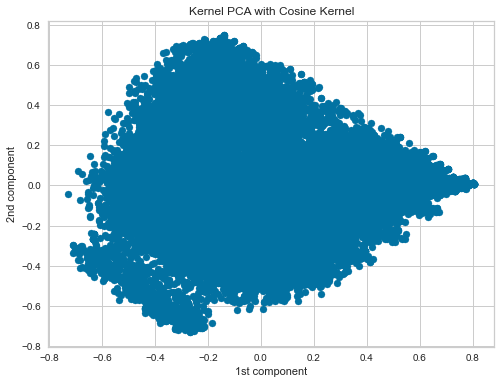

In [114]:
kpca = KernelPCA(n_components=2, kernel='cosine', gamma=0.1,random_state=0)
X_kpca = kpca.fit_transform(df_scaled1)

plt.figure(figsize=(8, 6))
plt.scatter(X_kpca[:, 0], X_kpca[:, 1])
plt.title("Kernel PCA with Cosine Kernel")
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

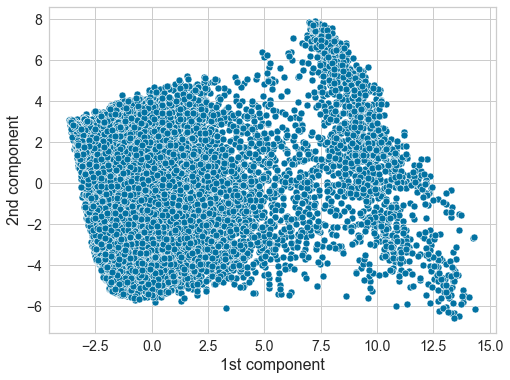

In [156]:
pca = PCA(n_components=2,random_state=0)
df_pca2 = pca.fit_transform(df_scaled1)
df_pca2 = pd.DataFrame(data=df_pca2, columns=['PC1', 'PC2'])

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=df_pca2)
# plt.title('PCA scatter plot')
plt.xlabel('1st component', fontsize=16)
plt.ylabel('2nd component', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

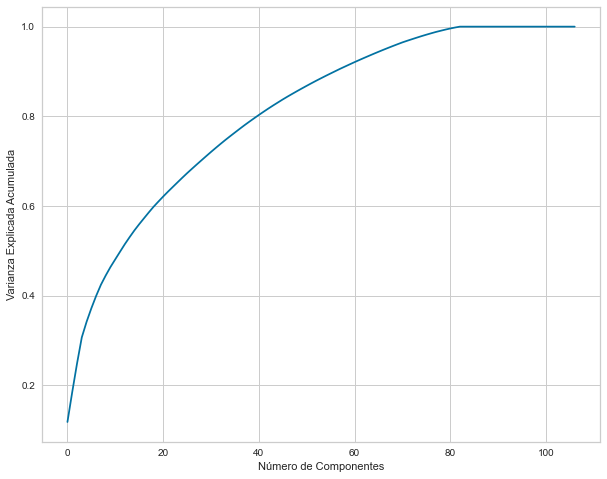

In [116]:
pca = PCA(random_state=0)
pca.fit(df_scaled1)

plt.figure(figsize=(10,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.grid(True)
plt.show()

In [117]:
# pca = PCA(n_components=60,random_state=0)
# df_pca = pca.fit_transform(df_scaled1)

# kpca = KernelPCA(n_components=50, kernel='cosine', gamma=0.1,random_state=0)
# df_pca = kpca.fit_transform(df_scaled1)

In [118]:
# pd.DataFrame(df_pca).to_csv('kernel_pca_acoso_17102024.csv',index=False)

In [164]:
df_pca = pd.read_csv('kernel_pca_acoso_17102024.csv').to_numpy()

In [165]:
from sklearn.mixture import GaussianMixture

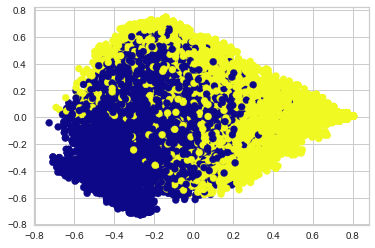

In [166]:
gmm = GaussianMixture(random_state=0,n_components=2)
cluster_labels = gmm.fit_predict(df_pca)
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=cluster_labels, cmap='plasma')

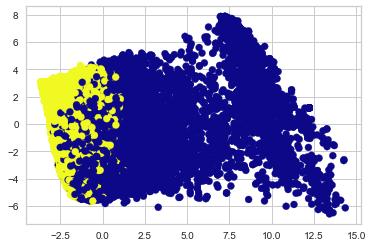

In [168]:
plt.scatter(df_pca2.to_numpy()[:, 0], df_pca2.to_numpy()[:, 1], c=cluster_labels, cmap='plasma')

In [169]:
df_rev1 = dfper[dfper['target'].isin([0])].copy()
df_rev1['segmento'] = cluster_labels

In [170]:
df_rev1['segmento'].value_counts()

0    10565
1     9088
Name: segmento, dtype: int64

# Graficando resultados

In [171]:
def grafica_por_dimension(df,
                          code_dimension,
                          code_question,
                          num_partitions,
                          max_char_per_line=50,
                          figsize=(10,6),
                          title=None,
                          cat_omit=None,x_legend = 0.91,y_legend = 0.5):
    if title == None:
        title = m_per[m_per['code']==f'{code_question}']['pregunta'].values[0]
    if cat_omit==None:
        agg_data = df.groupby([f'{code_dimension}',f'{code_question}']).agg(CTD_PERSONAS = ('ad_001','count')).reset_index()
        total_counts = df.groupby(f'{code_dimension}').agg(TOTAL_PERSONAS=('ad_001', 'count')).reset_index()
    elif cat_omit!=None:
        tmp = df[df[f'{code_question}']!=f'{cat_omit}']
        agg_data = tmp.groupby([f'{code_dimension}',f'{code_question}']).agg(CTD_PERSONAS = ('ad_001','count')).reset_index()
        total_counts = tmp.groupby(f'{code_dimension}').agg(TOTAL_PERSONAS=('ad_001', 'count')).reset_index()

    
    agg_data = agg_data.merge(total_counts, on=f'{code_dimension}',how='left')
    agg_data['PROPORCION'] = agg_data['CTD_PERSONAS'] / agg_data['TOTAL_PERSONAS']
    
    if len(title) > max_char_per_line:
        title = '\n'.join(textwrap.wrap(title, break_long_words=False, max_lines=num_partitions))

    category_mapping = {category: idx + 1 for idx, category in enumerate(agg_data[code_dimension].unique())}
    agg_data['category_num'] = agg_data[code_dimension].map(category_mapping)

    plt.figure(figsize=figsize)
    sns.barplot(data=agg_data, x=f'category_num', y='PROPORCION', hue=f'{code_question}')
    plt.title(f'{title}')
    plt.ylabel('Proporción (%)')
    plt.xlabel(f'{code_dimension}')
    plt.legend(title='Respuestas', bbox_to_anchor=(1.00, 1), loc='upper left')
    plt.xticks(rotation=0, ha='center', fontsize=10)
    
    category_legend = [f'{num}: {category}' for category, num in category_mapping.items()]
    plt.figtext(x_legend, y_legend, '\n'.join(category_legend), fontsize=10, ha='left')
    
    plt.show()

In [172]:
def grafica_por_dimension_relativa(df,
                          code_dimension,
                          code_question,
                          num_partitions,
                          max_char_per_line=50,
                          figsize=(10,6),
                          title=None,
                          cat_omit=None,x_legend = 0.91,y_legend = 0.5):
    if title == None:
        title = m_per[m_per['code']==f'{code_question}']['pregunta'].values[0]
    if cat_omit==None:
        agg_data = df.groupby([f'{code_dimension}',f'{code_question}']).agg(CTD_PERSONAS = ('ad_001','count')).reset_index()
        total_counts = df.groupby(f'{code_question}').agg(TOTAL_PERSONAS=('ad_001', 'count')).reset_index()
    elif cat_omit!=None:
        tmp = df[df[f'{code_question}']!=f'{cat_omit}']
        agg_data = tmp.groupby([f'{code_dimension}',f'{code_question}']).agg(CTD_PERSONAS = ('ad_001','count')).reset_index()
        total_counts = tmp.groupby(f'{code_question}').agg(TOTAL_PERSONAS=('ad_001', 'count')).reset_index()

    
    agg_data = agg_data.merge(total_counts, on=f'{code_question}',how='left')
    agg_data['PROPORCION'] = agg_data['CTD_PERSONAS'] / agg_data['TOTAL_PERSONAS']
    
    if len(title) > max_char_per_line:
        title = '\n'.join(textwrap.wrap(title, break_long_words=False, max_lines=num_partitions))

    category_mapping = {category: idx + 1 for idx, category in enumerate(agg_data[code_question].unique())}
    agg_data['category_num'] = agg_data[code_question].map(category_mapping)

    plt.figure(figsize=figsize)
    sns.barplot(data=agg_data, x=f'category_num', y='PROPORCION', hue=f'{code_dimension}',palette='tab10')
    plt.title(f'{title}')
    plt.ylabel('Proporción (%)')
    plt.xlabel(f'{code_question}')
    plt.legend(title='Segmentos', bbox_to_anchor=(1.00, 1), loc='upper left')
    plt.xticks(rotation=0, ha='center', fontsize=10)
    
    category_legend = [f'{num}: {category}' for category, num in category_mapping.items()]
    plt.figtext(x_legend, y_legend, '\n'.join(category_legend), fontsize=10, ha='left')
    
    plt.show()

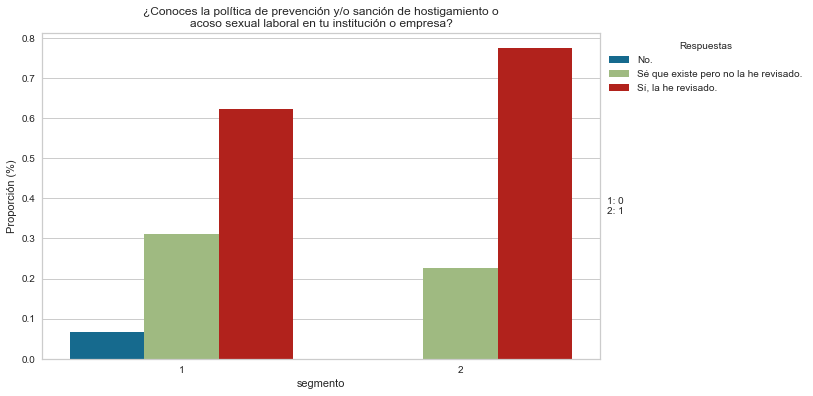

In [173]:
grafica_por_dimension(df_rev1,'segmento','sp_001',3,cat_omit='Otro',y_legend=0.46)

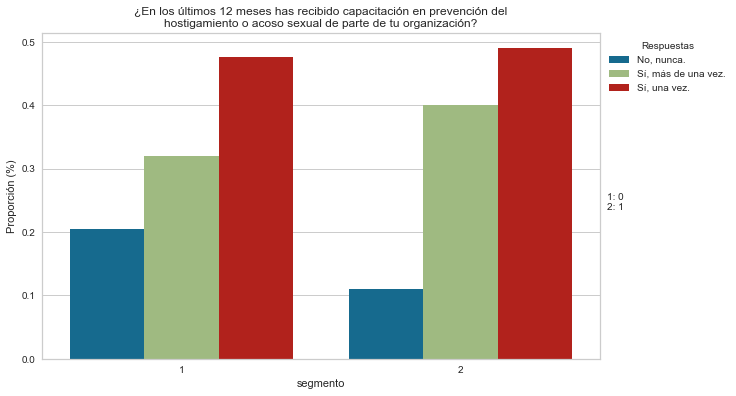

In [174]:
grafica_por_dimension(df_rev1,'segmento','sp_002',3,cat_omit='Otro',y_legend=0.47)

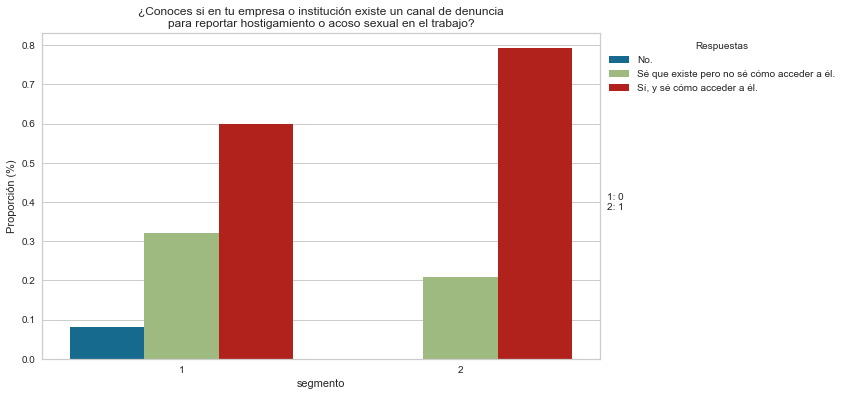

In [175]:
grafica_por_dimension(df_rev1,'segmento','sp_003',3,cat_omit='Otro',y_legend=0.47)

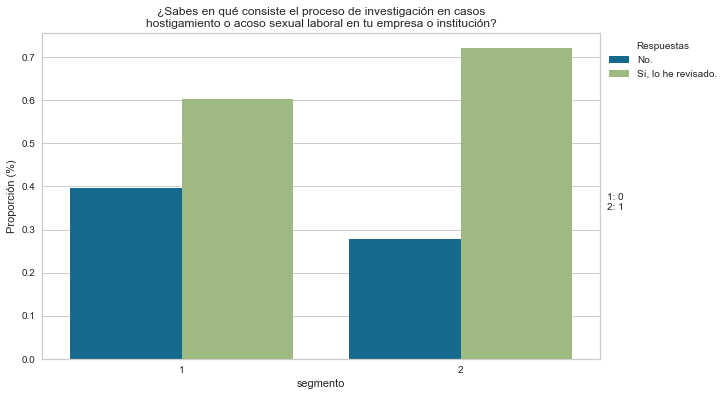

In [176]:
grafica_por_dimension(df_rev1,'segmento','sp_012',3,cat_omit='Otro',y_legend=0.47)

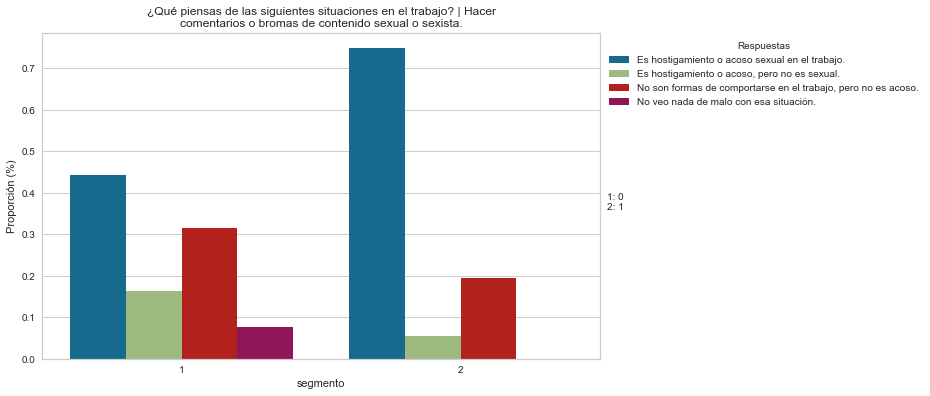

In [177]:
grafica_por_dimension(df_rev1,'segmento','tol_001',3,cat_omit='Otro',y_legend=0.47)

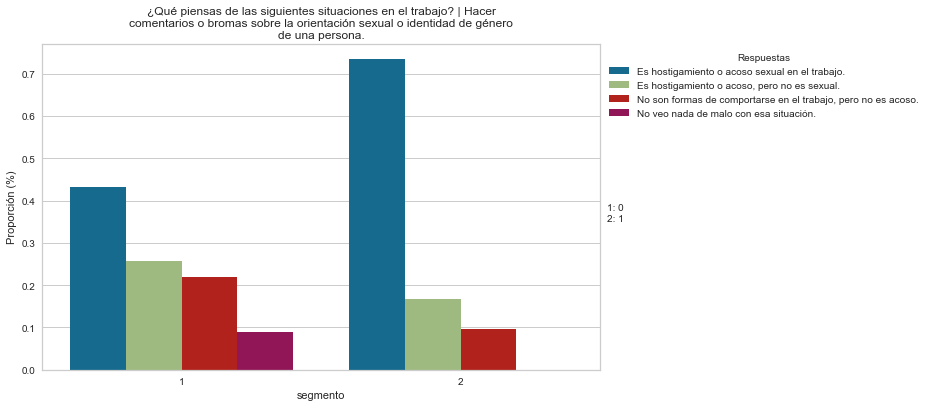

In [178]:
grafica_por_dimension(df_rev1,'segmento','tol_002',3,cat_omit='Otro',y_legend=0.47)

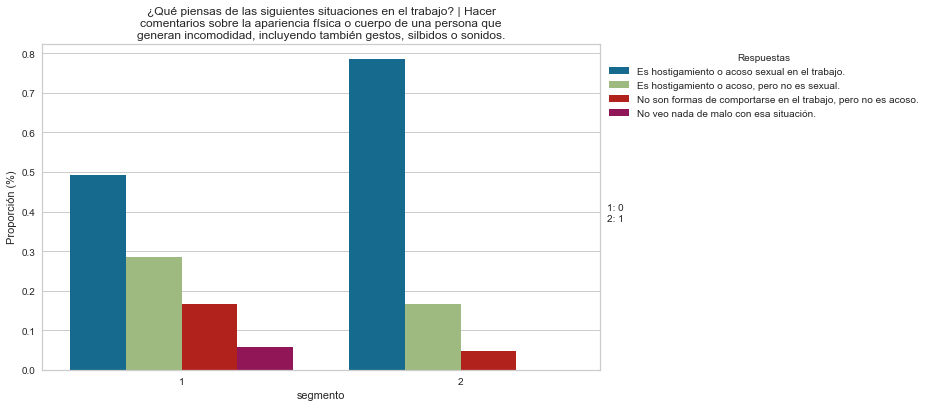

In [179]:
grafica_por_dimension(df_rev1,'segmento','tol_003',3,cat_omit='Otro',y_legend=0.47)

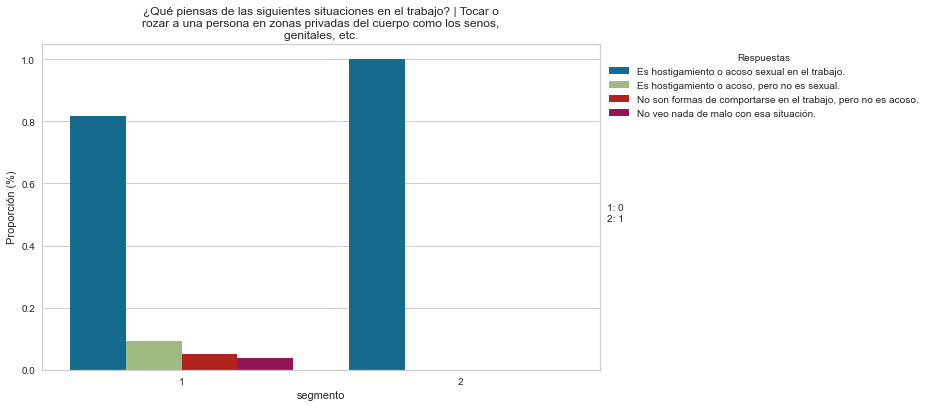

In [180]:
grafica_por_dimension(df_rev1,'segmento','tol_008',3,cat_omit='Otro',y_legend=0.47)

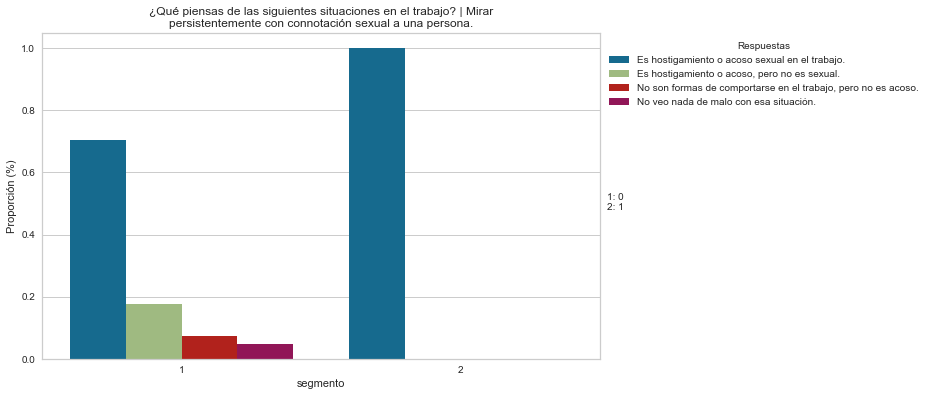

In [181]:
grafica_por_dimension(df_rev1,'segmento','tol_009',3,cat_omit='Otro',y_legend=0.47)

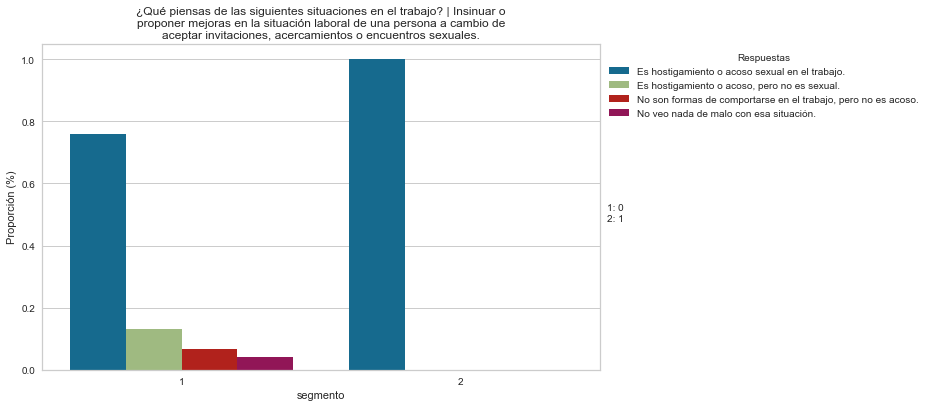

In [182]:
grafica_por_dimension(df_rev1,'segmento','tol_011',3,cat_omit='Otro',y_legend=0.47)

In [195]:
tolerancia = [col for col in dfper.columns if 'tol_' in col]
df_rev1['flg_tol_neg'] = df_rev1[tolerancia].apply(lambda row: 1 if any(x in ['No veo nada de malo con esa situación.', 'No son formas de comportarse en el trabajo, pero no es acoso.'] for x in row) else 0, axis=1)

In [196]:
df_rev1.groupby(['segmento','flg_tol_neg'])['measurement_process_id'].count().to_frame().reset_index()

,segmento,flg_tol_neg,measurement_process_id
0,0,0,4429
1,0,1,6136
2,1,0,6953
3,1,1,2135


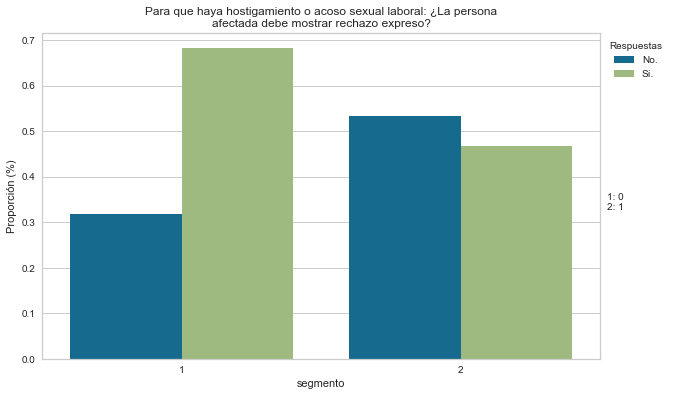

In [185]:
grafica_por_dimension(df_rev1,'segmento','cpt_001',3,cat_omit='Otro',y_legend=0.47)

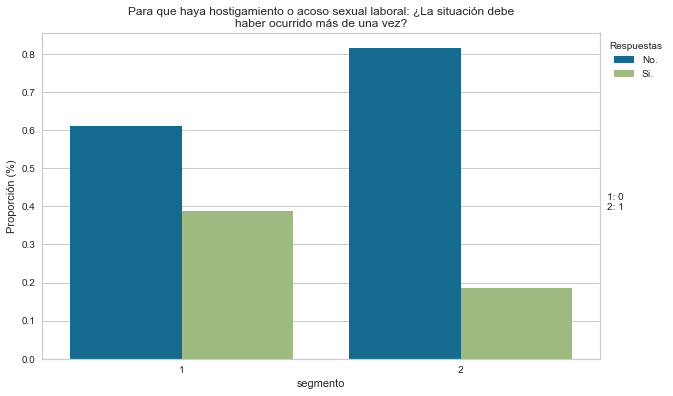

In [186]:
grafica_por_dimension(df_rev1,'segmento','cpt_002',3,cat_omit='Otro',y_legend=0.47)

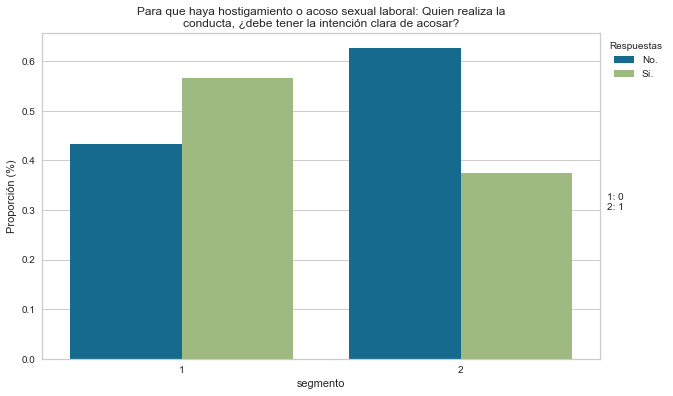

In [187]:
grafica_por_dimension(df_rev1,'segmento','cpt_003',3,cat_omit='Otro',y_legend=0.47)

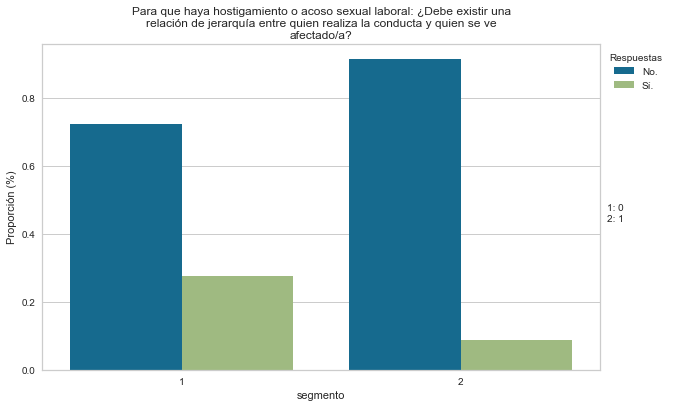

In [188]:
grafica_por_dimension(df_rev1,'segmento','cpt_004',3,cat_omit='Otro',y_legend=0.47)

In [197]:
# tolerancia = [col for col in dfper.columns if 'cpt_' in col]
# Repetitivo y jerarquia
tolerancia = ['cpt_002','cpt_004']
df_rev1['flg_cpt_neg'] = df_rev1[tolerancia].apply(lambda row: 1 if any(x in ['No.'] for x in row) else 0, axis=1)

In [198]:
df_rev1.groupby(['segmento','flg_cpt_neg'])['measurement_process_id'].count().to_frame().reset_index()

,segmento,flg_cpt_neg,measurement_process_id
0,0,0,2172
1,0,1,8393
2,1,0,543
3,1,1,8545


In [199]:
tolerancia = ['cpt_001','cpt_003']
# Repetitivo y jerarquia
df_rev1['flg_cpt_neg'] = df_rev1[tolerancia].apply(lambda row: 1 if any(x in ['No.'] for x in row) else 0, axis=1)

In [200]:
df_rev1.groupby(['segmento','flg_cpt_neg'])['measurement_process_id'].count().to_frame().reset_index()

,segmento,flg_cpt_neg,measurement_process_id
0,0,0,5071
1,0,1,5494
2,1,0,2656
3,1,1,6432


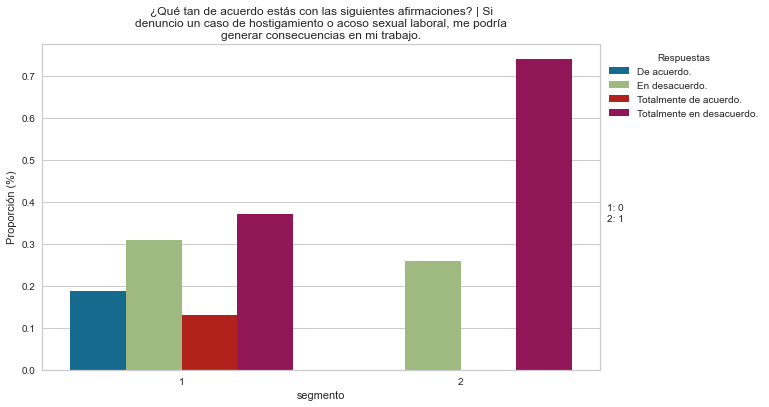

In [189]:
grafica_por_dimension(df_rev1,'segmento','con_001',3,cat_omit='Otro',y_legend=0.47)

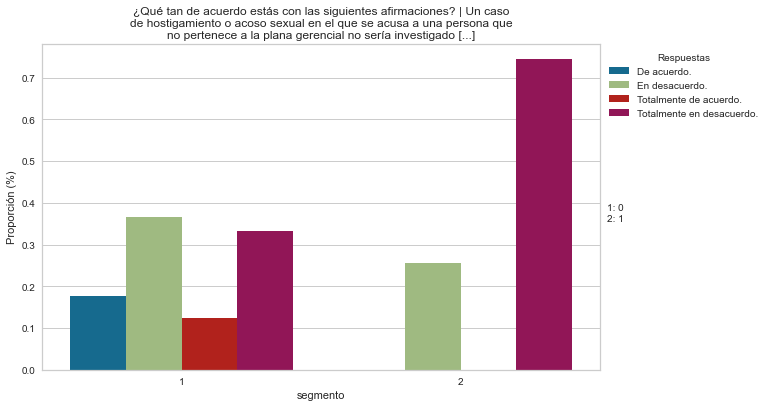

In [190]:
grafica_por_dimension(df_rev1,'segmento','con_002',3,cat_omit='Otro',y_legend=0.47)

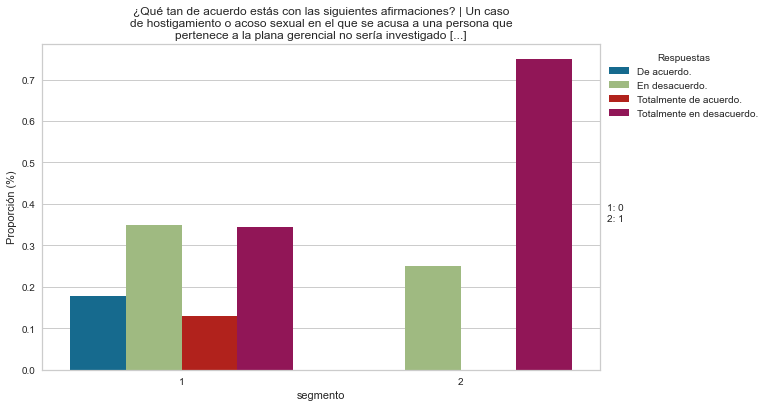

In [191]:
grafica_por_dimension(df_rev1,'segmento','con_003',3,cat_omit='Otro',y_legend=0.47)

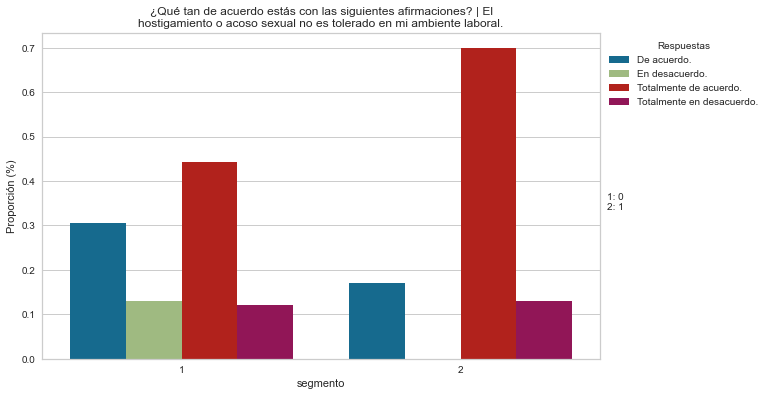

In [192]:
grafica_por_dimension(df_rev1,'segmento','con_004',3,cat_omit='Otro',y_legend=0.47)

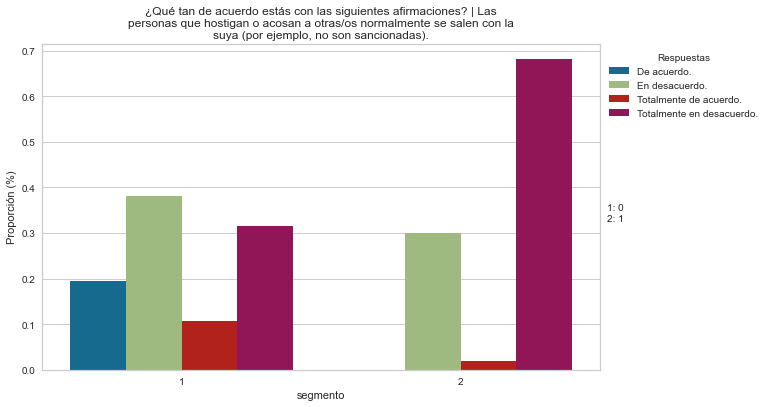

In [193]:
grafica_por_dimension(df_rev1,'segmento','con_005',3,cat_omit='Otro',y_legend=0.47)

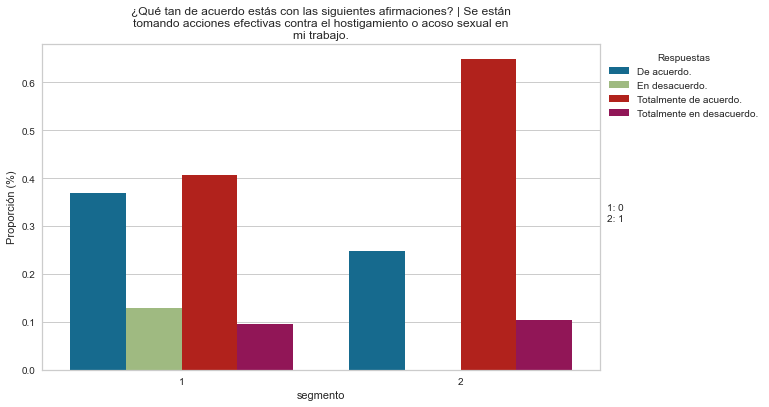

In [194]:
grafica_por_dimension(df_rev1,'segmento','con_006',3,cat_omit='Otro',y_legend=0.47)

In [201]:
tolerancia = ['con_004','con_006']
df_rev1['flg_con_neg'] = df_rev1[tolerancia].apply(lambda row: 1 if any(x in ['De acuerdo.','Totalmente de acuerdo.'] for x in row) else 0, axis=1)

In [202]:
df_rev1.groupby(['segmento','flg_con_neg'])['measurement_process_id'].count().to_frame().reset_index()

,segmento,flg_con_neg,measurement_process_id
0,0,0,1590
1,0,1,8975
2,1,0,607
3,1,1,8481


In [203]:
tolerancia = ['con_001','con_002','con_003','con_005']
df_rev1['flg_con_neg'] = df_rev1[tolerancia].apply(lambda row: 1 if any(x in ['De acuerdo.','Totalmente de acuerdo.'] for x in row) else 0, axis=1)

In [204]:
df_rev1.groupby(['segmento','flg_con_neg'])['measurement_process_id'].count().to_frame().reset_index()

,segmento,flg_con_neg,measurement_process_id
0,0,0,4582
1,0,1,5983
2,1,0,8914
3,1,1,174


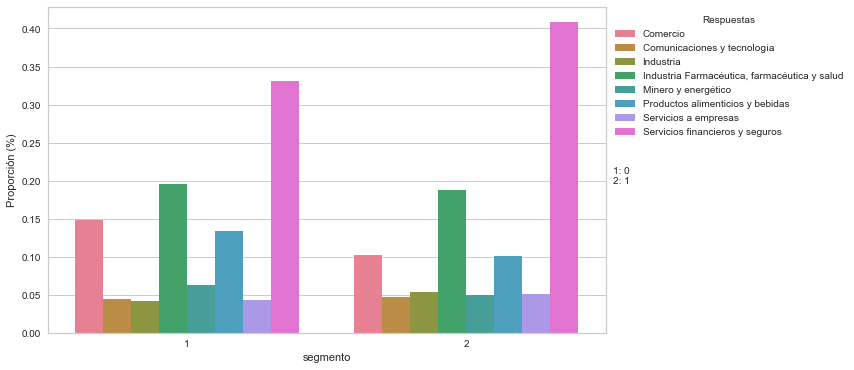

In [205]:
grafica_por_dimension(df_rev1,'segmento','name',3,cat_omit='Otro',y_legend=0.47,title='')

In [210]:
df_rev1['case_001_case_resolution'].value_counts(dropna=False,normalize=True)

NaN                          0.817992
Totalmente de acuerdo.       0.097848
De acuerdo.                  0.058261
En desacuerdo.               0.016537
Totalmente en desacuerdo.    0.009362
Name: case_001_case_resolution, dtype: float64

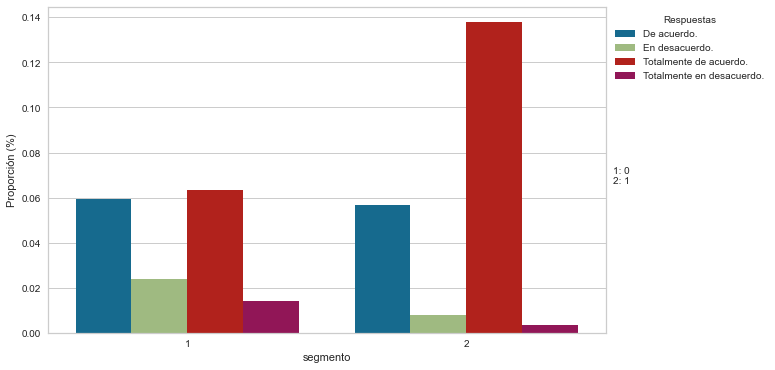

In [206]:
grafica_por_dimension(df_rev1,'segmento','case_001_case_resolution',3,cat_omit='Otro',y_legend=0.47,title='')

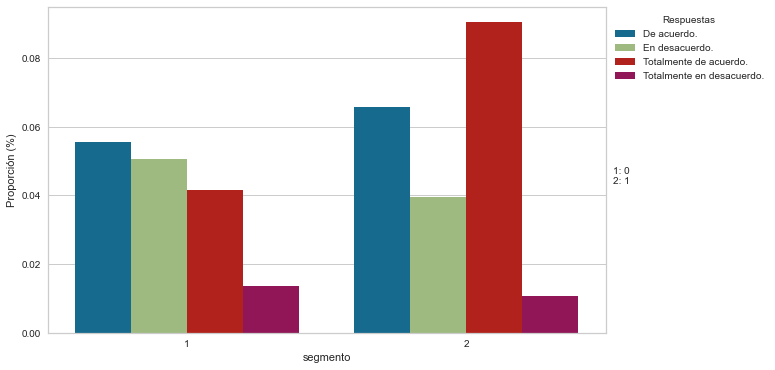

In [207]:
grafica_por_dimension(df_rev1,'segmento','case_002_case_resolution',3,cat_omit='Otro',y_legend=0.47,title='')

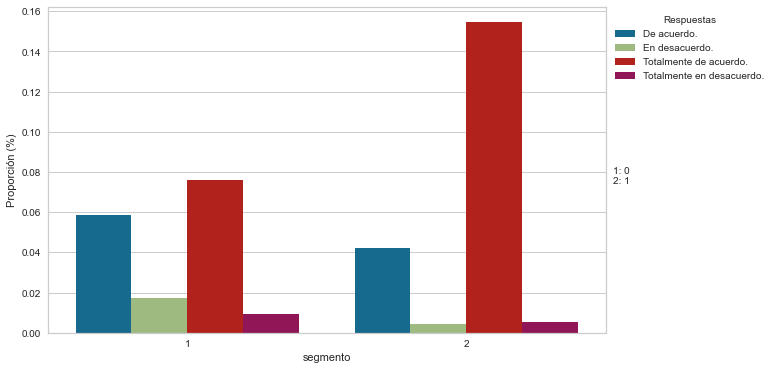

In [208]:
grafica_por_dimension(df_rev1,'segmento','case_003_case_resolution',3,cat_omit='Otro',y_legend=0.47,title='')

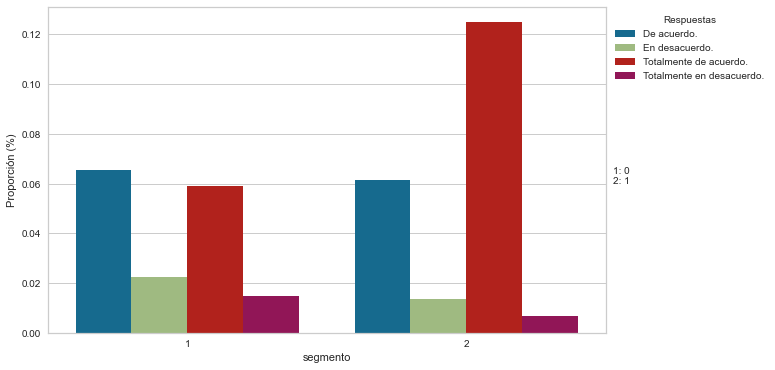

In [209]:
grafica_por_dimension(df_rev1,'segmento','case_004_case_resolution',3,cat_omit='Otro',y_legend=0.47,title='')

# Calculo de AUC

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

def calculate_auc_with_decision_tree(df, categorical_columns, target_column):
    le = LabelEncoder()
    df[target_column] = le.fit_transform(df[target_column])
    
    auc_scores = {}
    
    for col in categorical_columns:
        X = pd.get_dummies(df[col], prefix=col)
        y = df[target_column]
        
        clf = DecisionTreeClassifier(random_state=42)
        y_pred_proba = cross_val_predict(clf, X, y, cv=5, method='predict_proba')
    
        auc_per_class = []
        for i in range(len(le.classes_)):
            try:
                auc = roc_auc_score((y == i).astype(int), y_pred_proba[:, i])
                auc_per_class.append(auc)
            except ValueError:
                print(f"No se pudo calcular AUC para {col}, clase {i}")

        auc_scores[col] = np.mean(auc_per_class)
    
    return auc_scores

In [ ]:
categorical_columns = dfper.drop(columns=['target','measurement_process_id']).columns
target_column = 'target'
auc_scores = calculate_auc_with_decision_tree(dfper, categorical_columns, target_column)
print(auc_scores)

In [ ]:
dfauc = pd.DataFrame(zip(auc_scores.keys(),auc_scores.values()),columns=['variable','AUC'])

In [ ]:
dfauc.sort_values('AUC',ascending=False)